In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/90+_DaysPastDue/90+DPD_files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

check the distributions 

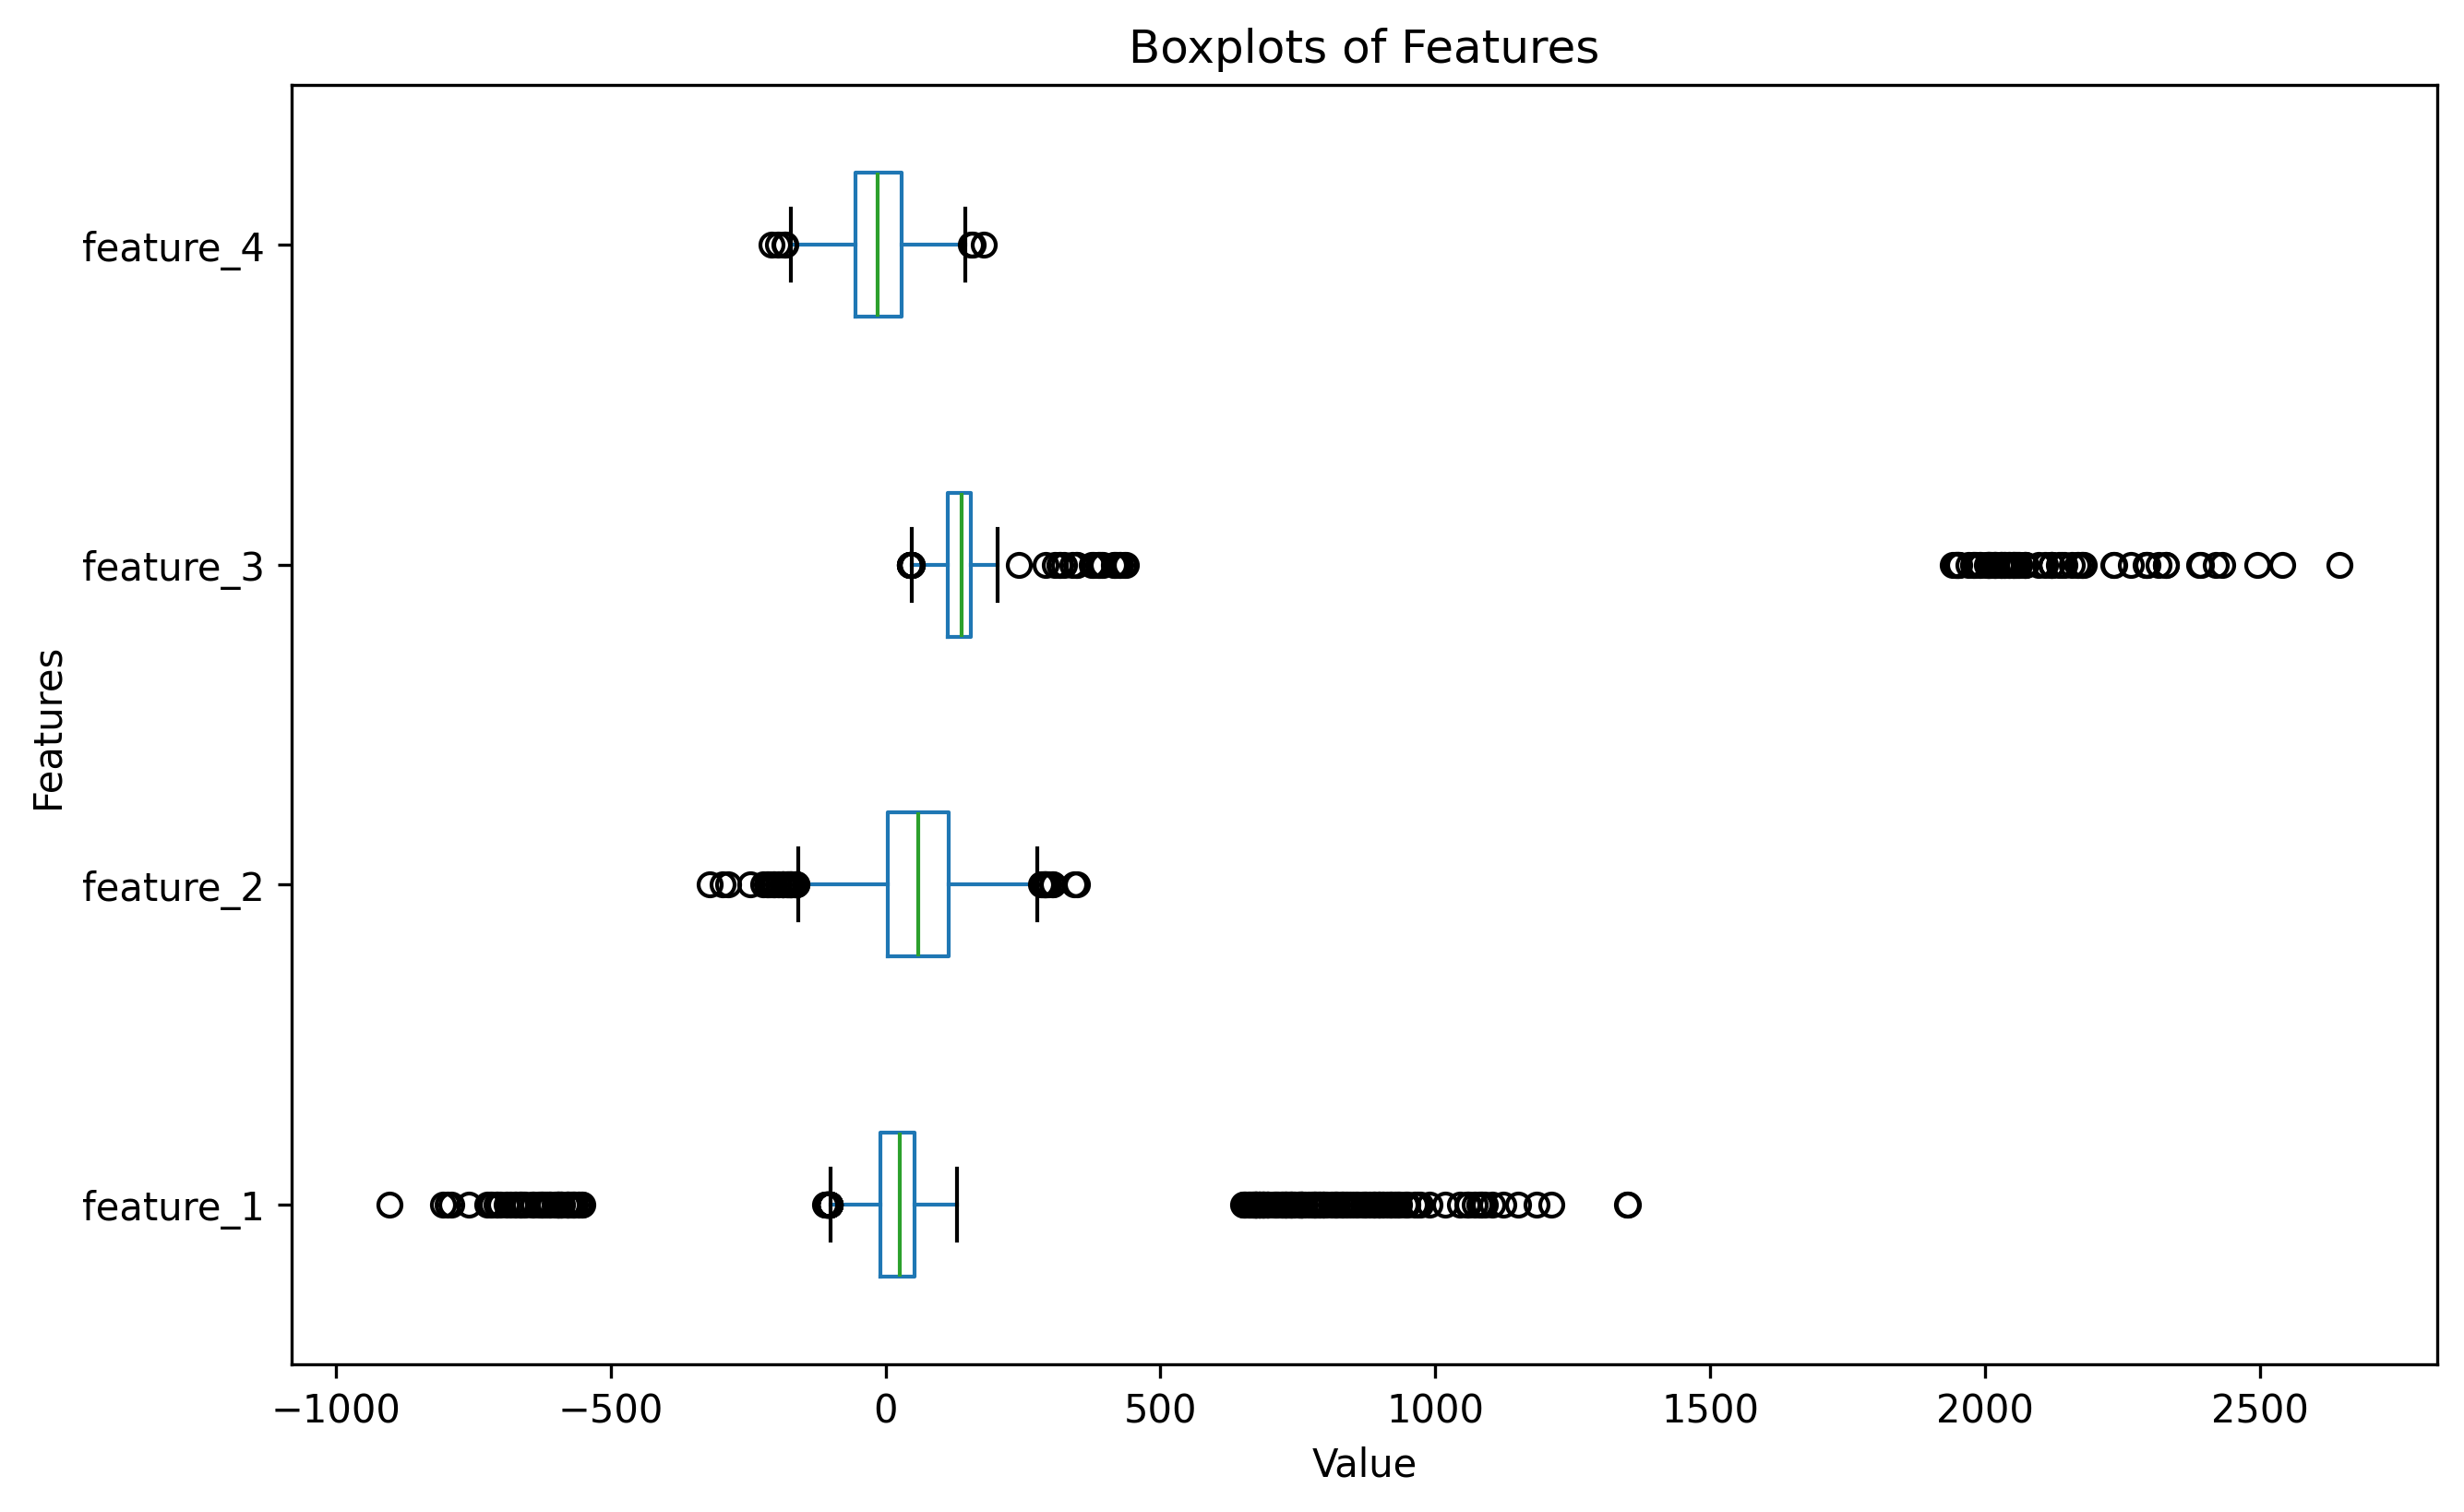

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

features = ["feature_1", "feature_2", "feature_3", "feature_4"]

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Create boxplot
train[features].boxplot(grid=False, vert=False)
plt.title("Boxplots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

The outliers of feature 3 will yeild disproportioate weight to the model parameter for feature 3 in whatever model we build. We we need to remove these outliers. 

In [3]:
# remove top 1 percent
threshold = train['feature_3'].quantile(0.99)

train.loc[train['feature_3'] > threshold, 'feature_3'] = pd.NA


# remove bottom 1 percent 
threshold = train['feature_3'].quantile(0.01)

train.loc[train['feature_3'] < threshold, 'feature_3'] = pd.NA


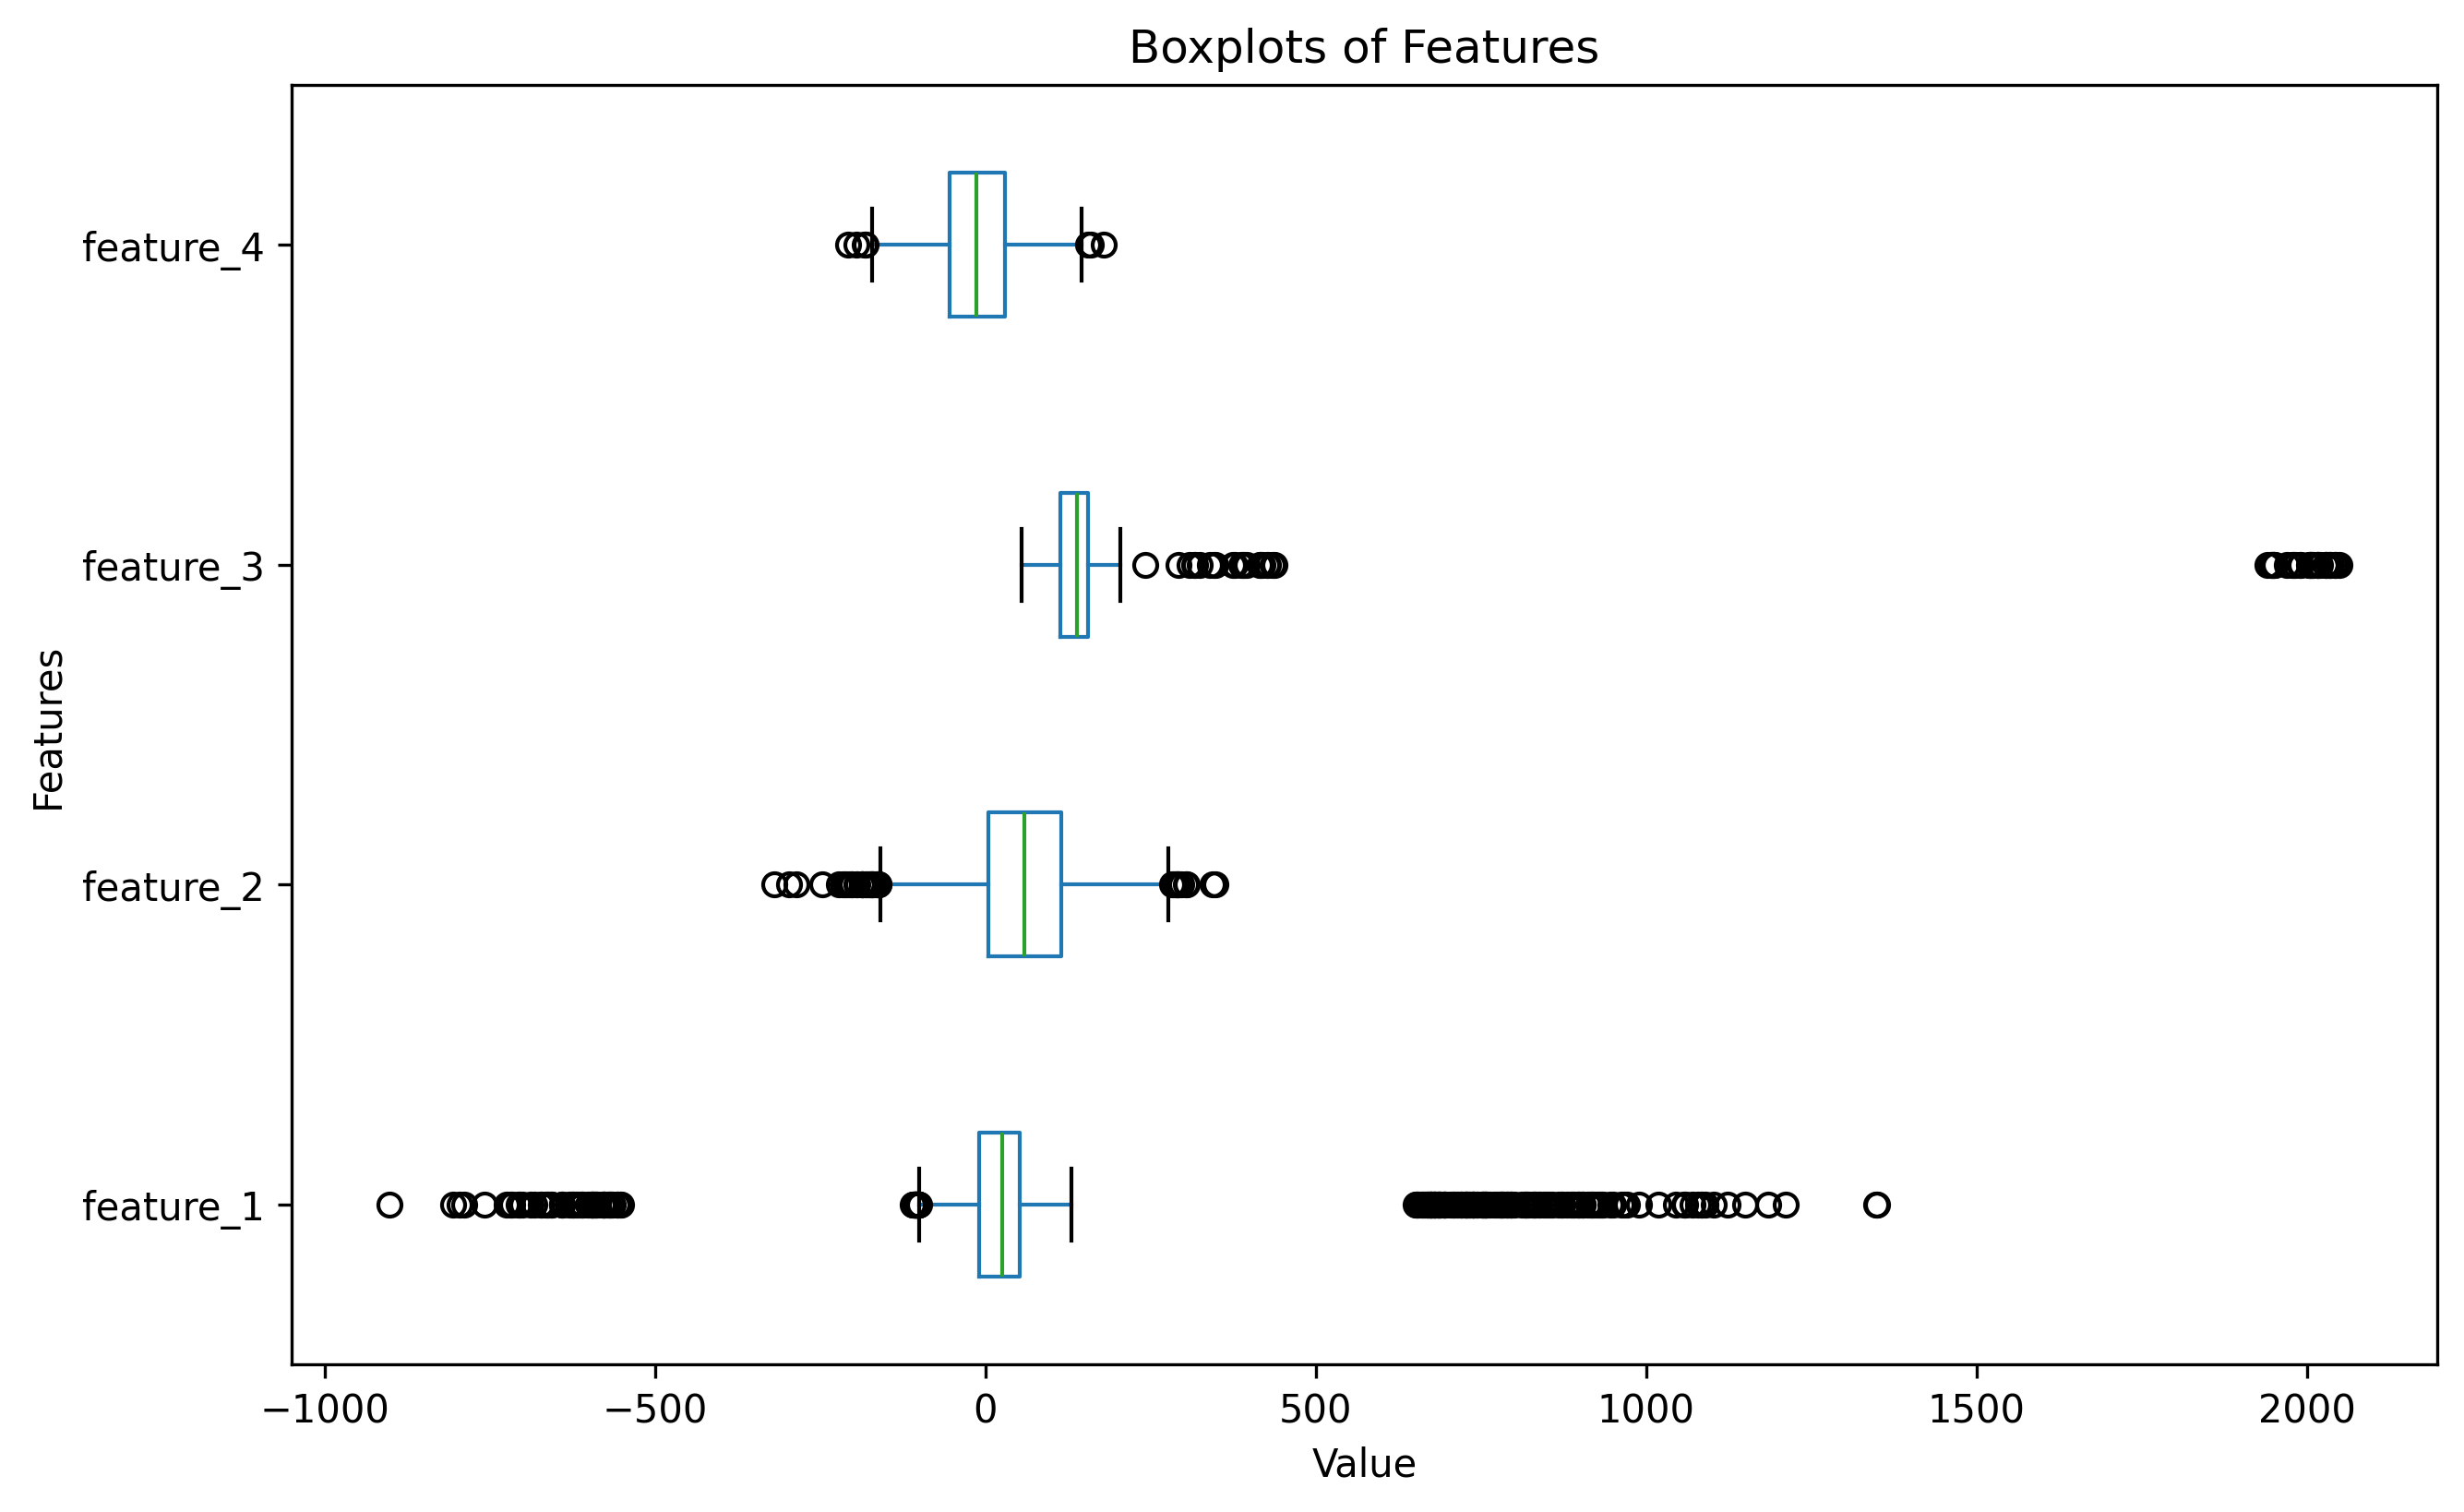

In [4]:

import pandas as pd
import matplotlib.pyplot as plt

features = ["feature_1", "feature_2", "feature_3", "feature_4"]

plt.figure(figsize=(10, 6), dpi=300)  # High-quality figure

# Create boxplot
train[features].boxplot(grid=False, vert=False)
plt.title("Boxplots of Features")
plt.xlabel("Value")
plt.ylabel("Features")
plt.show()

replace those values we just removed with median 

In [5]:
median_value = train['feature_3'].median()

train['feature_3'].fillna(median_value, inplace=True)

train.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)


median_value = test['feature_3'].median()

test['feature_3'].fillna(median_value, inplace=True)

test.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)

sort by ID and date so that if feature 2 is missing we can replace it with the next year or the previous years value

In [6]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])  
    df['feature_2'] = df['feature_2'].fillna(method='bfill') 
    df['feature_2'] = df['feature_2'].fillna(method='ffill') 
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

train.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)
test.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)

train = train.dropna(subset=['feature_2_impute'])
test = test.dropna(subset=['feature_2_impute'])

encode outocomes to 1 and 0 

In [7]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

In [8]:
display(train.head())

,feature_1,feature_2_impute,feature_3_impute,feature_4,id,date,y
0,39.165085,60.253765,137.986051,-35.462685,50501,2000,0
1,-12.614289,57.959237,126.212293,44.420647,50501,2001,1
2,0.043813,-39.293907,138.687175,64.944112,50501,2002,0
3,2.296984,49.996686,123.782456,-3.587873,50501,2003,0
4,7.188897,-83.533230,150.102046,95.359641,50501,2004,0


Now that all the NA's are gone, 

Preliminary diagnostics for suitability of Logistic Regression. 

In [9]:
import statsmodels.api as sm

predictor = train[['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']]
response = train['y']

predictor_with_const = sm.add_constant(predictor)

logit_model = sm.Logit(response, predictor_with_const)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.391865
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 3941
Model:                          Logit   Df Residuals:                     3936
Method:                           MLE   Df Model:                            4
Date:                Sun, 22 Dec 2024   Pseudo R-squ.:                  0.2260
Time:                        16:48:59   Log-Likelihood:                -1544.3
converged:                       True   LL-Null:                       -1995.2
Covariance Type:            nonrobust   LLR p-value:                7.393e-194
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4857      0.261     13.381      0.000       2.975       3.996
feature_1  

The Pseduo R-square is 0.2260, which begs the question of are these variables actually predictors of the response.

Here are the log(p/1-p) curves for each predictor from the model

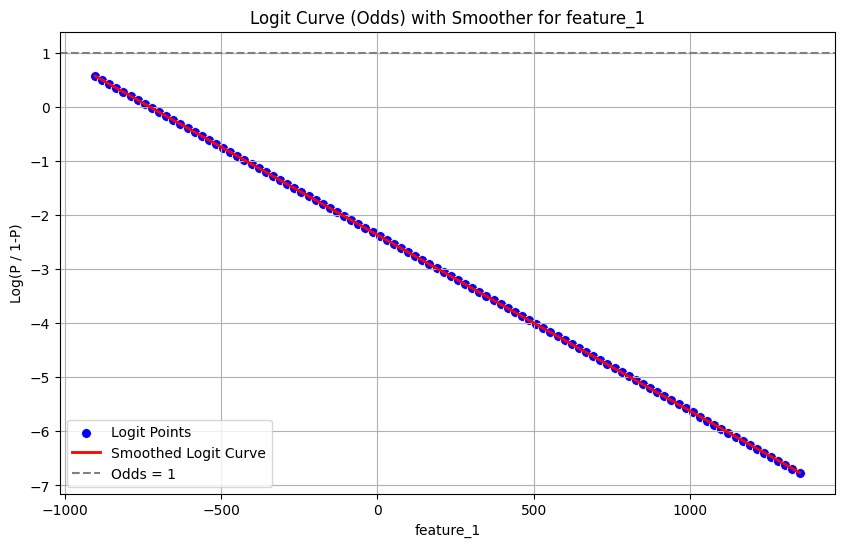

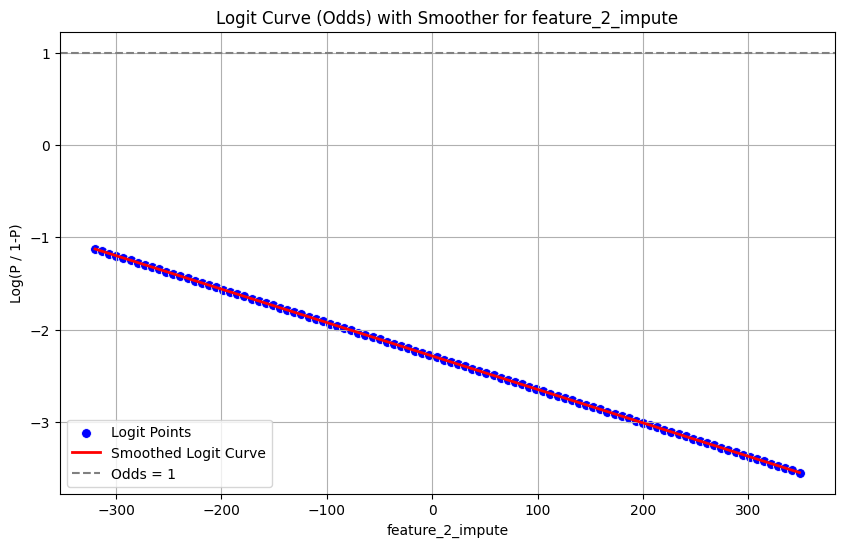

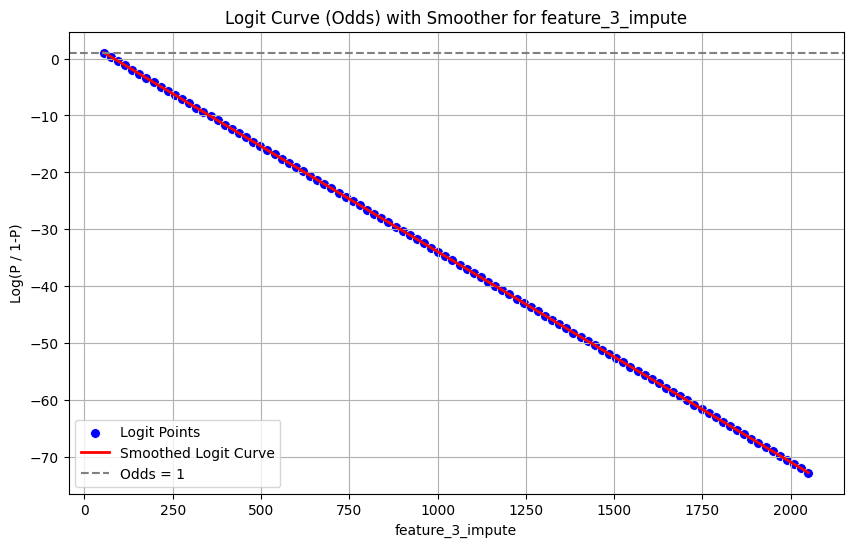

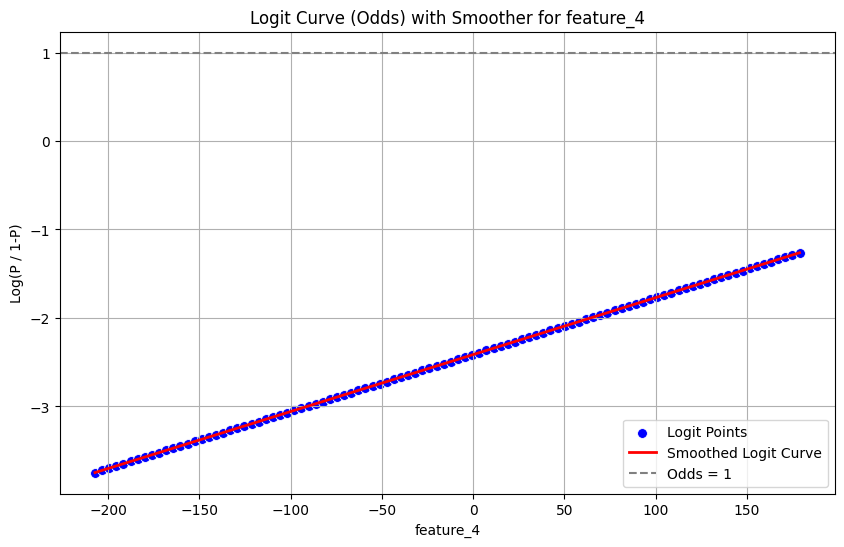

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

def plot_logit_curve_with_smoother(result, predictor, feature_name):
    """
    Plot the logit curve (odds) for a given feature with scatter points and a smoother.

    Parameters:
    - result: Fitted logistic regression model.
    - predictor: Training dataset of predictors.
    - feature_name: The feature for which to plot the logit curve.
    """
    # Generate a range of values for the selected feature
    feature_values = np.linspace(predictor[feature_name].min(), predictor[feature_name].max(), 100)
    
    # Keep other predictors fixed at their mean
    fixed_predictors = predictor.mean(axis=0).copy()
    
    # Calculate the logit (odds) for each feature value
    log_odds = []
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature_name] = value
        
        # Add constant and ensure shape matches model coefficients
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        #odds = np.exp(logit)  this is ploting the log(p/1-p) i just ommited the exp()
        log_odds.append(logit[0])
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        feature_name: feature_values,
        'log_odds': log_odds
    })
    
    # Plot the logit curve with points and smoother
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=feature_name, y='log_odds', data=plot_df, color='blue', s=50, label='Logit Points')
    sns.regplot(x=feature_name, y='log_odds', data=plot_df, scatter=False, lowess=True, 
                color='red', line_kws={'lw': 2}, label='Smoothed Logit Curve')
    
    plt.title(f'Logit Curve (Odds) with Smoother for {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Log(P / 1-P)')
    plt.axhline(1, color='grey', linestyle='--', label='Odds = 1')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_logit_curve_with_smoother(result, predictor, 'feature_1')
plot_logit_curve_with_smoother(result, predictor, 'feature_2_impute')
plot_logit_curve_with_smoother(result, predictor, 'feature_3_impute')
plot_logit_curve_with_smoother(result, predictor, 'feature_4')

We need to verify that the predictor response relationship demonstraighted in the models logit curves are actually representative of the relationship of the variables within the data. That is to say, the model shows predictive power, but is that actually the case.

Are these variables actually predictors of the outcome

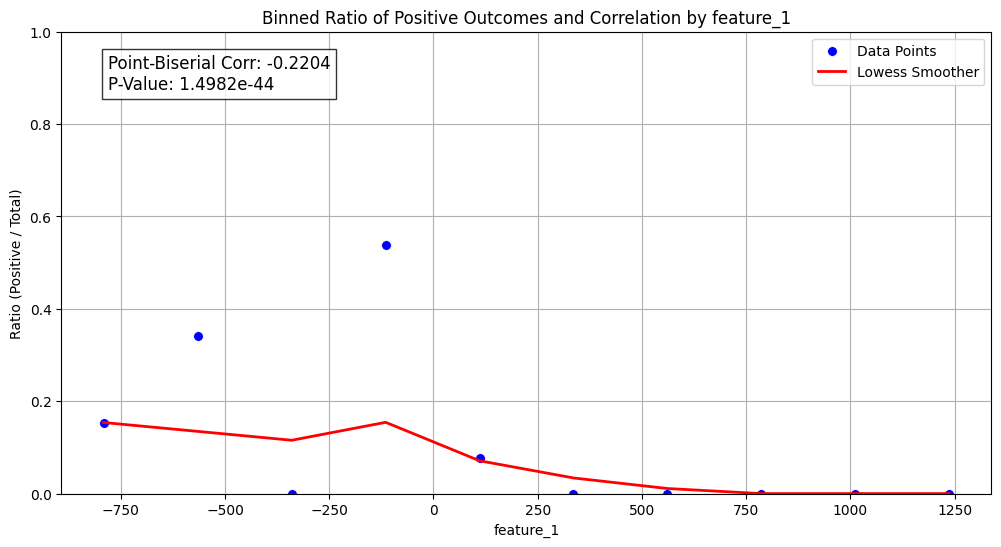

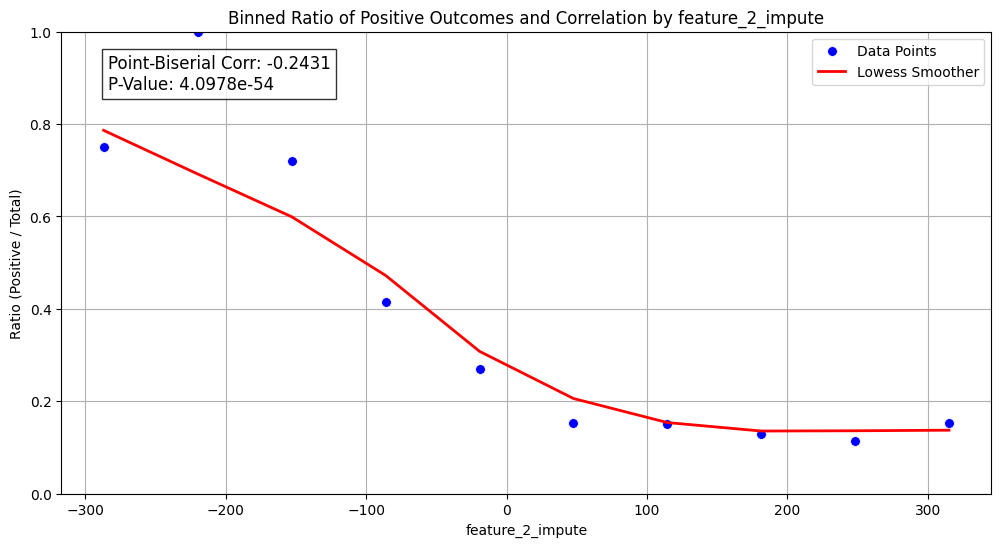

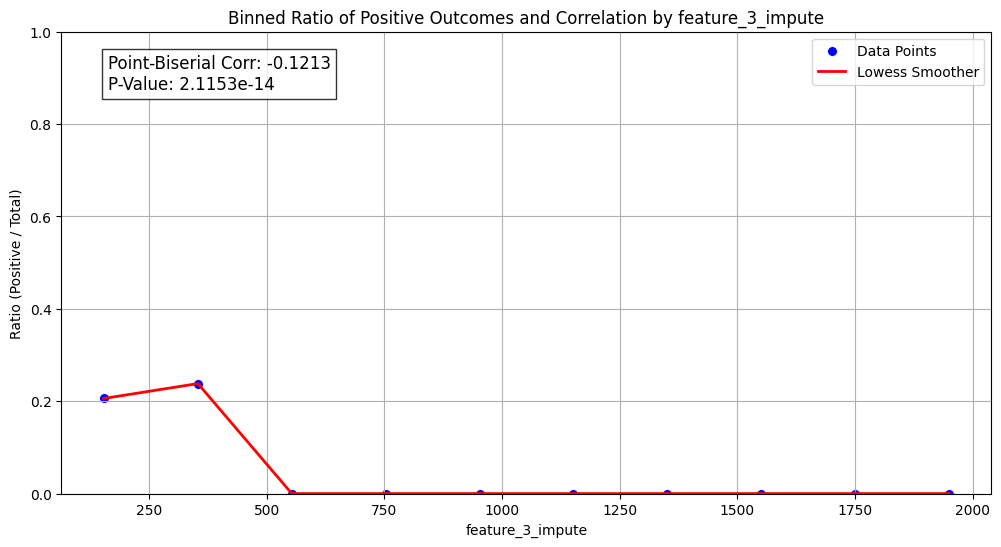

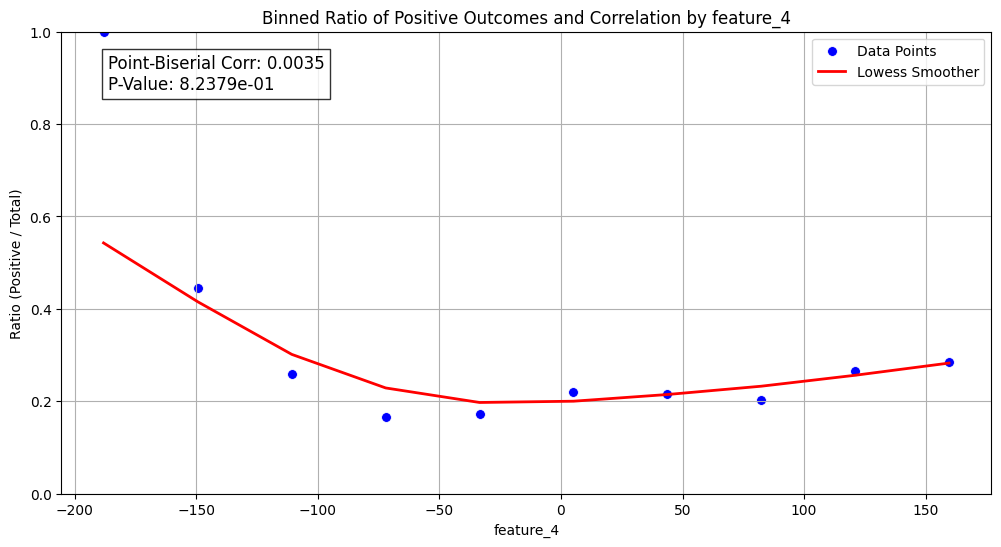

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr_binned(df, continuous_var, categorical_var='target', positive_value=1, negative_value=0, bins=10):
    """
    Plot the ratio of positive to total outcomes for a binned continuous variable with a scatter plot
    and display the correlation coefficient.
    
    Parameters:
    - df: DataFrame containing the data.
    - continuous_var: Name of the continuous predictor column.
    - categorical_var: Name of the binary target column.
    - positive_value: Value representing positive outcomes (default=1).
    - negative_value: Value representing negative outcomes (default=0).
    - bins: Number of bins to divide the continuous variable (default=10).
    """
    # Bin the continuous variable
    df['binned'] = pd.cut(df[continuous_var], bins=bins, include_lowest=True)
    
    # Group by binned variable and category to get counts
    grouped = df.groupby(['binned', categorical_var]).size().reset_index(name='count')
    
    # Pivot so we have positive and negative counts
    pivot = grouped.pivot(index='binned', columns=categorical_var, values='count').fillna(0)
    
    # Extract positive and total counts
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts

    # To avoid division by zero, add a small epsilon
    epsilon = 1e-9
    ratio = positive_counts / (total_counts + epsilon)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'binned': ratio.index.astype(str),  # Convert bin intervals to strings for plotting
        'ratio_positive_negative': ratio.values,
        continuous_var: [interval.mid for interval in ratio.index]  # Extract midpoints for x-axis
    })
    
    # Calculate Point-Biserial Correlation (on original data)
    correlation, p_value = pointbiserialr(df[continuous_var], df[categorical_var])
    
    # Plot the points and smoother
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of ratio points
    sns.scatterplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, color='blue', s=50, label='Data Points')

    # Add a smooth trend line (lowess)
    sns.regplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, 
                scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother')

    # Add the correlation coefficient as text on the plot
    plt.text(0.05, 0.95, f'Point-Biserial Corr: {correlation:.4f}\nP-Value: {p_value:.4e}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Final plot settings
    plt.title(f'Binned Ratio of Positive Outcomes and Correlation by {continuous_var}')
    plt.xlabel(continuous_var)
    plt.ylabel('Ratio (Positive / Total)')
    plt.ylim(0, 1)  # Ratio ranges between 0 and 1
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
plot_ratio_positive_negative_with_corr_binned(train, 'feature_1', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(train, 'feature_2_impute', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(train, 'feature_3_impute', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(train, 'feature_4', 'y', positive_value=1, negative_value=0, bins=10)

feature 2 is alright but that's not enough, checking the distributions next to see if that has what we want.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_combined_box_plots_2x2(df, predictor_vars, categorical_var='target'):
    """
    Create a 2x2 grid of box plots for each predictor variable, grouped by the categorical outcome,
    and include mean annotations for each group within each plot.
    
    Parameters:
    - df: pandas DataFrame containing the data.
    - predictor_vars: List of predictor variables for which box plots will be created.
    - categorical_var: The categorical outcome variable to group by.
    """
    # Melt the dataframe for easier faceted plotting
    melted_df = df[predictor_vars + [categorical_var]].melt(
        id_vars=categorical_var,
        var_name="Predictor",
        value_name="Value"
    )
    
    # Create a facet grid with box plots
    g = sns.catplot(
        data=melted_df,
        x=categorical_var,
        y="Value",
        col="Predictor",
        kind="box",
        height=4,
        aspect=0.9,
        col_wrap=2,  # Ensures a 2x2 grid
        sharey=False,
    )
    
    # Annotate each plot with means
    for ax, predictor in zip(g.axes.flat, predictor_vars):
        category_means = df.groupby(categorical_var)[predictor].mean()
        mean_text = "\n".join([f"{cat}: {mean:.2f}" for cat, mean in category_means.items()])
        ax.text(
            0.95, 0.95,
            mean_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment="top",
            horizontalalignment="right",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        )
    
    # Set titles and adjust layout
    g.fig.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Box Plots of Predictors by {categorical_var}')
    plt.show()

# Example usage
plot_combined_box_plots_2x2(train, predictor_vars, categorical_var='y')

NameError: name 'predictor_vars' is not defined

feature 2 isn't bad as a predictor, but this alone will not generate the predictive power we need for this model.

due to the many outliers, the plot of the distributions of the variables by outcome does not demonstraight a big difference 

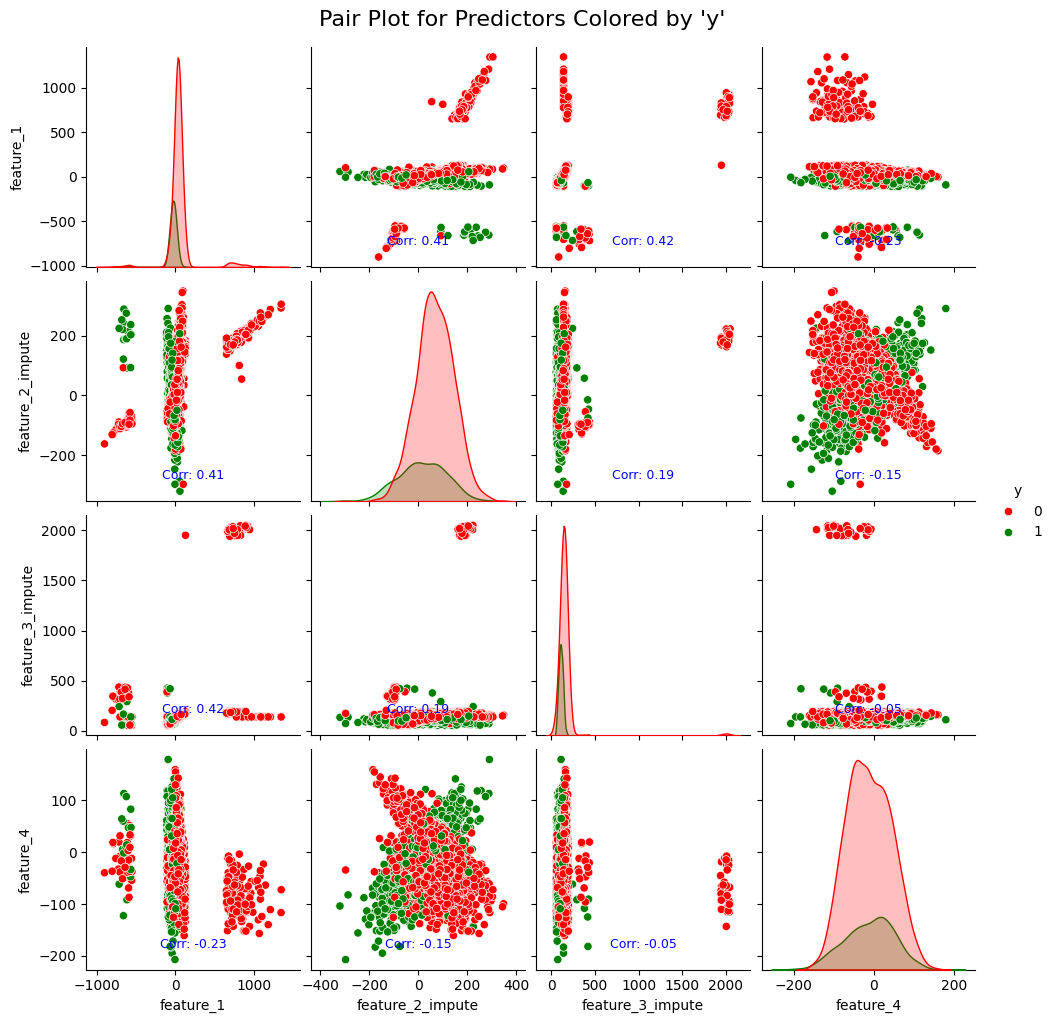

In [644]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_full_pairplot_with_corr(df, continuous_vars, target_var='target', positive_value=1, negative_value=0):
    """
    Generate a Seaborn pair plot with correlation coefficients annotated on the scatter plots,
    showing a full matrix.

    Parameters:
    - df: DataFrame containing the data.
    - continuous_vars: List of continuous variable column names.
    - target_var: Name of the binary target column (default='target').
    - positive_value: Value representing positive outcomes (default=1).
    - negative_value: Value representing negative outcomes (default=0).
    """
    # Filter DataFrame for the required columns
    pairplot_data = df[continuous_vars + [target_var]].copy()
    
    # Ensure the target variable is categorical for coloring
    pairplot_data[target_var] = pairplot_data[target_var].astype('category')
    
    # Calculate pairwise correlations
    correlation_matrix = pairplot_data[continuous_vars].corr()
    
    # Create the pair plot
    g = sns.pairplot(
        pairplot_data,
        hue=target_var,
        palette={positive_value: 'green', negative_value: 'red'},
        diag_kind='kde',
        corner=False
    )
    
    # Annotate correlation coefficients
    for i, row_var in enumerate(continuous_vars):
        for j, col_var in enumerate(continuous_vars):
            if i != j:  # Skip diagonal
                # Get the current axis
                ax = g.axes[i, j]
                # Get the correlation value
                corr = correlation_matrix.loc[row_var, col_var]
                # Annotate the correlation on the scatter plot
                ax.annotate(
                    f"Corr: {corr:.2f}",
                    xy=(0.5, 0.1),
                    xycoords="axes fraction",
                    ha="center",
                    fontsize=9,
                    color="blue"
                )
    
    # Add a title for context
    plt.suptitle(f"Pair Plot for Predictors Colored by '{target_var}'", y=1.02, fontsize=16)
    plt.show()

# Continuous variables and target variable
# Call the function for the specific data
continuous_vars_1 = ['age', 'dist', 'income', 'marital_status', 'gender']
target_var = 'target'


# You can call the function again for a different set of variables if needed
continuous_vars_2 = ['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']
response_var_2 = 'y'

plot_full_pairplot_with_corr(train, continuous_vars_2, response_var_2, positive_value=1, negative_value=0)

This tells us that feature 2 and feature 4 is where we will be getting predictive power in our model and that this data is suitable for logistic regression.

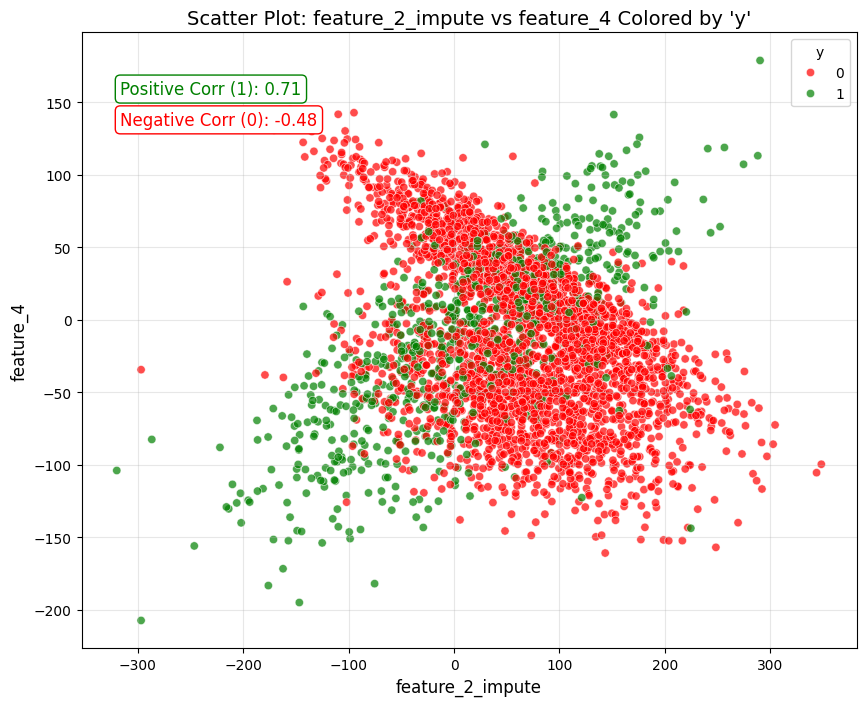

In [645]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_single_scatter_with_corr_by_category(df, feature_x, feature_y, target_var='target', positive_value=1, negative_value=0):
    """
    Plot a full-sized scatter plot of two features with correlation annotated for each category.

    Parameters:
    - df: DataFrame containing the data.
    - feature_x: Name of the x-axis feature.
    - feature_y: Name of the y-axis feature.
    - target_var: Name of the binary target column.
    - positive_value: Value representing positive outcomes.
    - negative_value: Value representing negative outcomes.
    """
    # Ensure the target variable is categorical for coloring
    df[target_var] = df[target_var].astype('category')

    # Calculate correlation for each category
    positive_corr = df[df[target_var] == positive_value][feature_x].corr(df[df[target_var] == positive_value][feature_y])
    negative_corr = df[df[target_var] == negative_value][feature_x].corr(df[df[target_var] == negative_value][feature_y])

    # Create the scatter plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x=feature_x,
        y=feature_y,
        hue=target_var,
        palette={positive_value: 'green', negative_value: 'red'},
        alpha=0.7
    )

    # Annotate correlation for positive and negative categories
    plt.annotate(
        f"Positive Corr ({positive_value}): {positive_corr:.2f}",
        xy=(0.05, 0.9),
        xycoords="axes fraction",
        ha="left",
        fontsize=12,
        color="green",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="green", facecolor="white")
    )
    plt.annotate(
        f"Negative Corr ({negative_value}): {negative_corr:.2f}",
        xy=(0.05, 0.85),
        xycoords="axes fraction",
        ha="left",
        fontsize=12,
        color="red",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white")
    )

    # Set plot labels and title
    plt.title(f"Scatter Plot: {feature_x} vs {feature_y} Colored by '{target_var}'", fontsize=14)
    plt.xlabel(feature_x, fontsize=12)
    plt.ylabel(feature_y, fontsize=12)
    plt.legend(title=target_var, loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()

# Example usage
plot_single_scatter_with_corr_by_category(train, 'feature_2_impute', 'feature_4', target_var='y', positive_value=1, negative_value=0)

that's it we found it. .71 correlation betweeen feature 2 and 4 for their points coresponding to posative outcomes. 